In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import random
%matplotlib inline

In [40]:
args = {'lr':0.01,
        'train epochs':5000,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler()
        }

In [41]:
df = pd.read_excel('data_3nm.xlsx')

In [42]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [43]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [44]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [45]:
# add noise
X_noisy = add_noise(X, args['noise'])

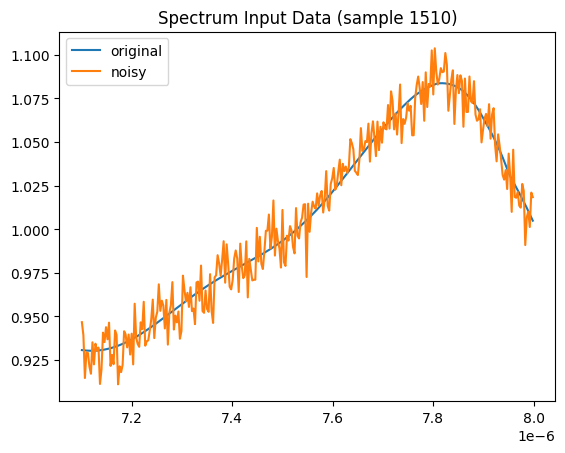

In [46]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry][-300:], label='original')
plt.plot(X_noisy.iloc[entry][-300:], label='noisy')
plt.legend()
plt.show()

In [47]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.fit_transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=69)

In [49]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [50]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin_input = nn.Linear(input_size, 45)
        self.hidden1 = nn.Linear(45, 9)
        self.lin_output = nn.Linear(9, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin_input(x))
        x = F.leaky_relu(self.hidden1(x))
        x = self.lin_output(x)
        return x

In [51]:
criterion = args['train criterion']
model = Net(X_train_tensor.size()[1], y_train_tensor.size()[1])
optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

print(model)

Net(
  (lin_input): Linear(in_features=1417, out_features=45, bias=True)
  (hidden1): Linear(in_features=45, out_features=9, bias=True)
  (lin_output): Linear(in_features=9, out_features=11, bias=True)
)


In [52]:
best_loss = np.inf
best_epoch = 0
train_losses = []
valid_losses = []

for epoch in range(args['train epochs']):
    # forward pass
    outputs = model(X_train_tensor)

    # get loss
    loss = criterion(outputs, y_train_tensor)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    valid_pred = model(X_test_tensor)
    valid_loss = criterion(valid_pred, y_test_tensor)
    valid_losses.append(valid_loss.item())

    if (epoch+1) % int(args['train epochs']/10) == 0:
        print(f'epoch = {epoch+1},'.ljust(13) + f' train loss = {loss:.3f},'.ljust(21) + f' valid loss = {valid_loss.item():.3f}')

print(f'\nbest training loss: {best_loss:.3f} in epoch {best_epoch}\n')  

epoch = 500,  train loss = 3.956,  valid loss = 4.599
epoch = 1000, train loss = 3.518,  valid loss = 4.372
epoch = 1500, train loss = 3.425,  valid loss = 4.332
epoch = 2000, train loss = 3.403,  valid loss = 4.316
epoch = 2500, train loss = 3.385,  valid loss = 4.301
epoch = 3000, train loss = 3.375,  valid loss = 4.295
epoch = 3500, train loss = 3.369,  valid loss = 4.291
epoch = 4000, train loss = 3.363,  valid loss = 4.287
epoch = 4500, train loss = 3.358,  valid loss = 4.283
epoch = 5000, train loss = 3.353,  valid loss = 4.280

best training loss: 3.353 in epoch 5000



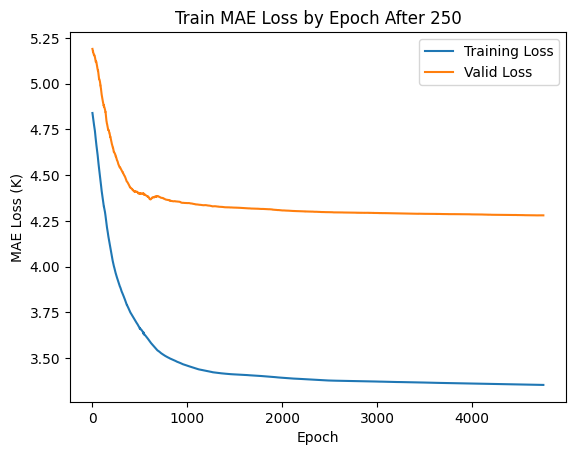

In [53]:
plt.plot(train_losses[250:], label='Training Loss')
plt.plot(valid_losses[250:], label='Valid Loss')

    
plt.title("Train MAE Loss by Epoch After 250")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [54]:
test_criterion = args['test criterion']

print('Test Losses')
with torch.no_grad():
    model.eval()
    pred = model(X_test_tensor)
    loss = test_criterion(pred, y_test_tensor)

    print(f'Overall: {loss.item()}\n')

    pred_layers = []
    for i in range(pred.size(1)):
        column = pred[:, i]
        pred_layers.append(column)

    actual_layers = []
    for i in range(y_test_tensor.size(1)):
        column = y_test_tensor[:, i]
        actual_layers.append(column)

    for i in range(y_test_tensor.size(1)):
        loss = test_criterion(pred_layers[i], actual_layers[i])
        
        print(f'Layer {i+1}: {loss.item()}')



Test Losses
Overall: 4.280023097991943

Layer 1: 3.810945987701416
Layer 2: 7.939034461975098
Layer 3: 4.1688456535339355
Layer 4: 4.064656734466553
Layer 5: 5.373154640197754
Layer 6: 4.701828956604004
Layer 7: 5.063621520996094
Layer 8: 3.8082659244537354
Layer 9: 3.886028528213501
Layer 10: 2.8743793964385986
Layer 11: 1.3894948959350586


In [55]:
pred_df = pd.DataFrame(pred.numpy())

In [56]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

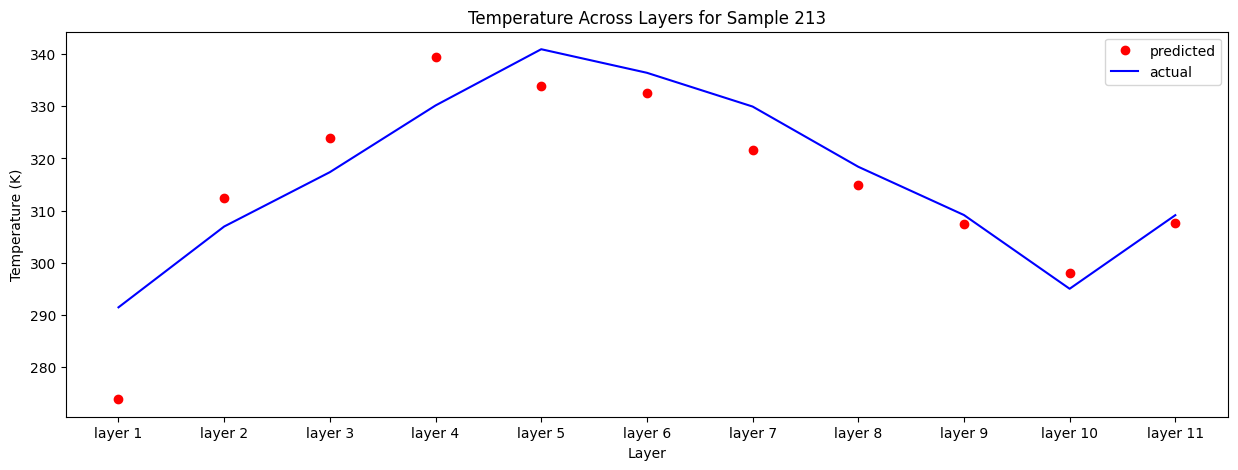

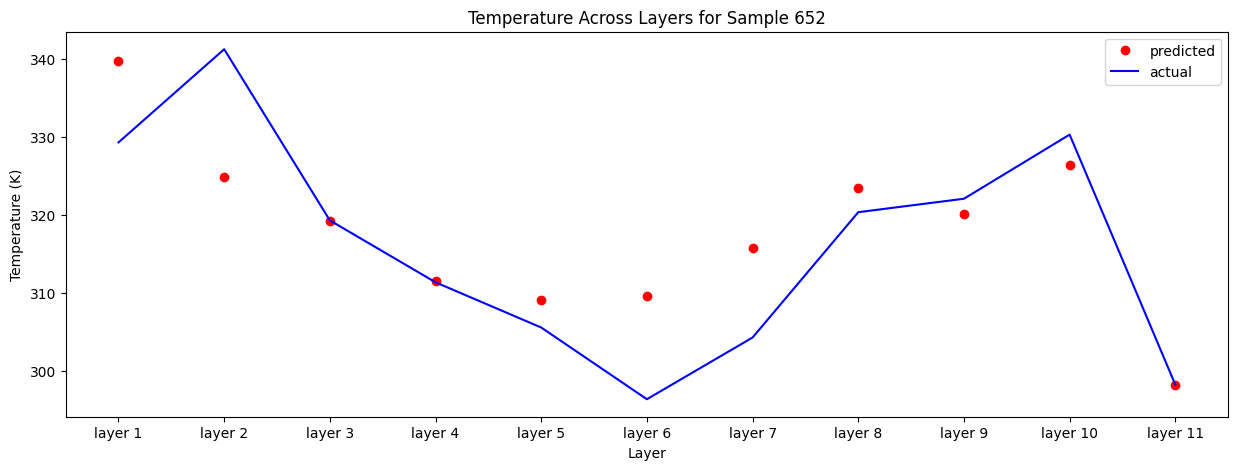

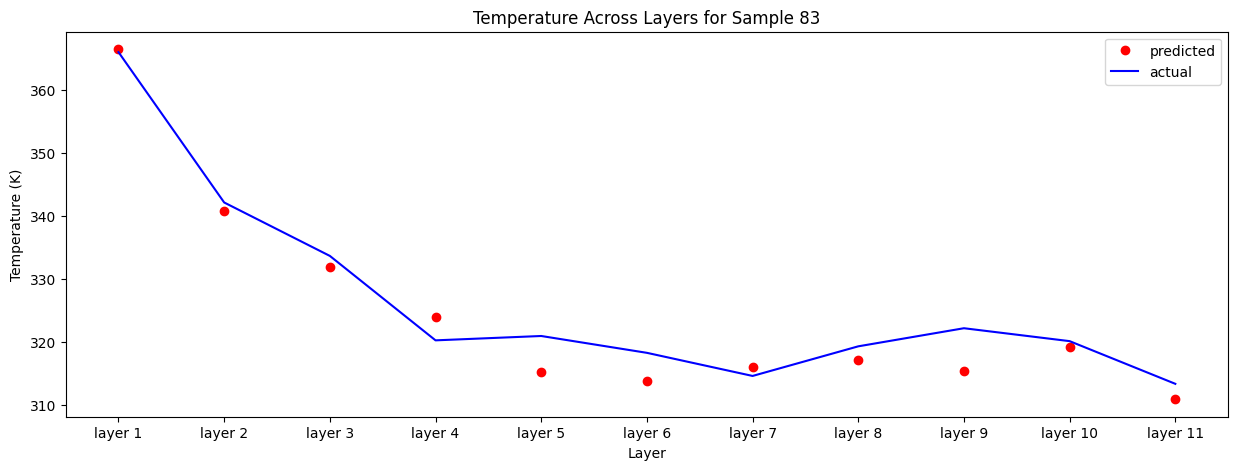

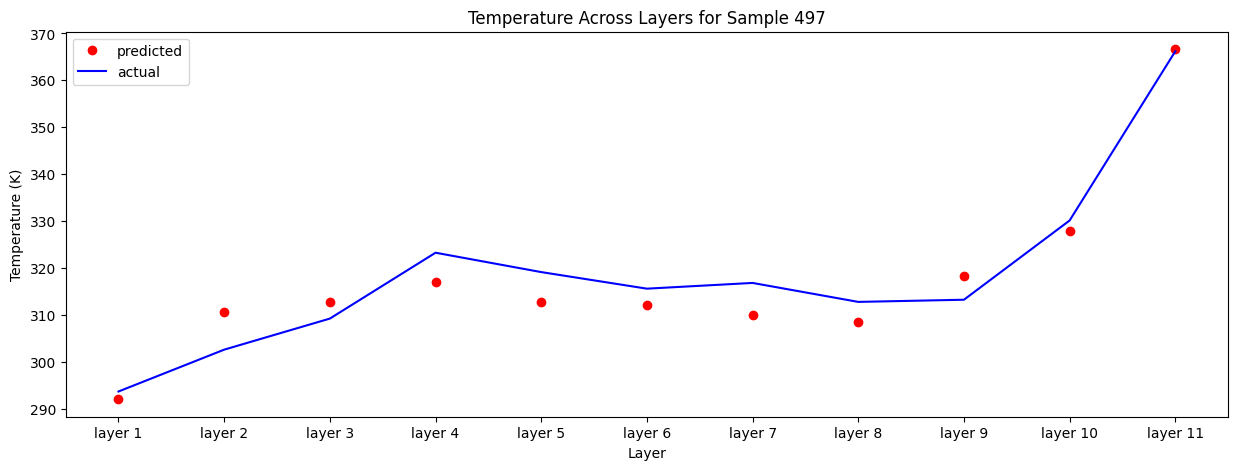

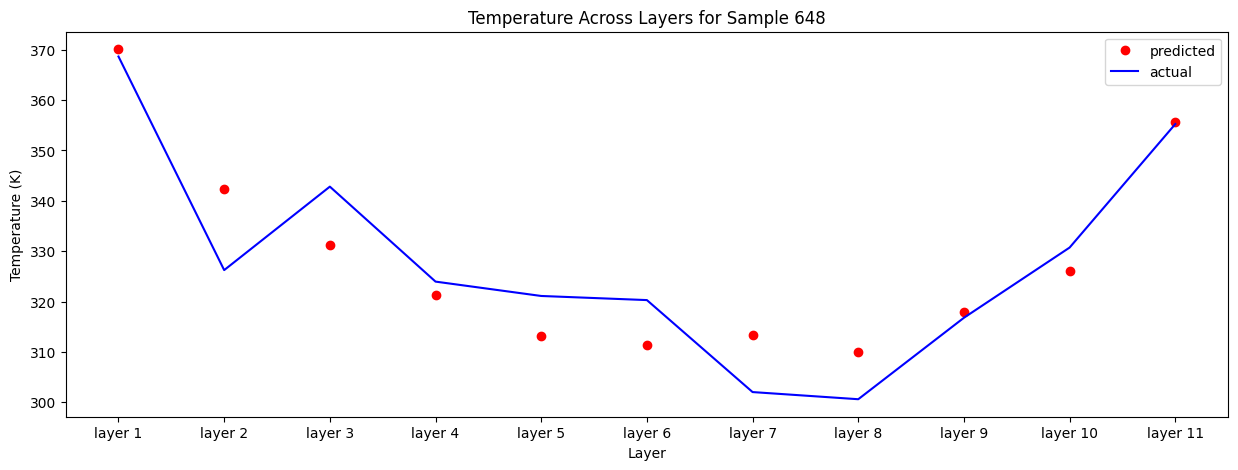

In [57]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    a = y_test.iloc[i,:]
    p = pred_df.iloc[i,:]

    plot_comparison(p, a, i)